# Initialization
This was the given initialization.

## Loading of modules & GPU Check

In [0]:
#!ls
#%cd /content/keras_triplet_descriptor
#!git pull


In [0]:
# Taken from
# https://stackoverflow.com/questions/48750199/google-colaboratory-misleading-information-about-its-gpu-only-5-ram-available
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
!pip install livelossplot

  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
  Stored in directory: /root/.cache/pip/wheels/bf/66/07/e3129f723b6b36ee4affde650ad6843fceaf5c2fa5dc29b986
Successfully built livelossplot


In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
  process = psutil.Process(os.getpid())
  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

In [0]:
printm()

Gen RAM Free: 12.9 GB  | Proc size: 142.3 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


## Download & Unpack the data (Run only if not done already)

In [0]:
# Clone repo
!git clone https://github.com/MatchLab-Imperial/keras_triplet_descriptor
# Change directory
%cd /content/keras_triplet_descriptor
!git checkout 719576a29567a9a2b86658496eea7f196bc314f6
# Download data
!wget -O hpatches_data.zip https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
# Extract data
!unzip -q ./hpatches_data.zip
!rm ./hpatches_data.zip

Cloning into 'keras_triplet_descriptor'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 172 (delta 21), reused 22 (delta 10), pack-reused 128
Receiving objects: 100% (172/172), 149.84 MiB | 10.84 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Checking out files: 100% (69/69), done.
/content/keras_triplet_descriptor
--2019-02-20 10:16:04--  https://imperialcollegelondon.box.com/shared/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip
Resolving imperialcollegelondon.box.com (imperialcollegelondon.box.com)... 107.152.25.197, 107.152.24.197
Connecting to imperialcollegelondon.box.com (imperialcollegelondon.box.com)|107.152.25.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.zip [following]
--2019-02-20 10:16:05--  https://imperialcollegelondon.box.com/public/static/ah40eq7cxpwq4a6l4f62efzdyt8rm3ha.

## Imports of modules

In [0]:
import sys, json, os, glob, time, cv2, random
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda, Reshape, Subtract
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization 
from keras.layers import Input, UpSampling2D, concatenate  
from keras.utils import plot_model
import tensorflow as tf
import numpy as np
from read_data import HPatches, DataGeneratorDesc, hpatches_sequence_folder, DenoiseHPatches, tps
from utils import generate_desc_csv, plot_denoise, plot_triplet
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

Using TensorFlow backend.


## Fixation of seeds 

In [0]:
random.seed(1234)
np.random.seed(1234)
tf.set_random_seed(1234)

## Loading of splits

In [0]:
# Change if you wish to train, otherwise the models will be directly loaded
denoise_train = True
descriptor_train = True

hpatches_dir = './hpatches'
splits_path = './splits.json'

splits_json = json.load(open(splits_path, 'rb'))

split = splits_json['a']

train_fnames = split['train']
test_fnames = split['test']

seqs = glob.glob(hpatches_dir+'/*')
seqs = [os.path.abspath(p) for p in seqs]   
seqs_train = list(filter(lambda x: x.split('/')[-1] in train_fnames, seqs)) 
seqs_test = list(filter(lambda x: x.split('/')[-1] in split['test'], seqs)) 

## Enable ploting of loss per batch

In [0]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []


    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# Model definitions
The baseline remains unchaged.



In [0]:
SHAPE = (32, 32, 1)

def get_denoise_model(shape):
  inputs = Input(shape)
  conv1 = Conv2D(16, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  ## Bottleneck
  conv2 = Conv2D(32, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)

  ## Now the decoder starts
  up3 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv2))
  merge3 = concatenate([conv1,up3], axis = -1)
  conv3 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge3)
    
  conv4 = Conv2D(1, 3,  padding = 'same')(conv3)

  shallow_unet = Model(inputs = inputs, outputs = conv4)
  return shallow_unet


def get_descriptor_model(shape):
  '''Architecture copies HardNet architecture'''
  init_weights = keras.initializers.he_normal()
  descriptor_model = Sequential()
  descriptor_model.add(Conv2D(32, 3, padding='same', input_shape=shape, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(32, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', strides=2, use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(64, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', strides=2,  use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))

  descriptor_model.add(Conv2D(128, 3, padding='same', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(BatchNormalization(axis = -1))
  descriptor_model.add(Activation('relu'))
  descriptor_model.add(Dropout(0.3))

  descriptor_model.add(Conv2D(128, 8, padding='valid', use_bias = True, kernel_initializer=init_weights))
  descriptor_model.add(Reshape((128,)))
  return descriptor_model

def get_descriptor_model_connected(shape):
  xa = Input(shape=shape, name='a')
  xp = Input(shape=shape, name='p')
  xn = Input(shape=shape, name='n')
  descriptor_model = get_descriptor_model(shape)
  ea = descriptor_model(xa)
  ep = descriptor_model(xp)
  en = descriptor_model(xn)

  loss = Lambda(triplet_loss)([ea, ep, en])
  model = Model(inputs = [xa, xp, xn], outputs = loss)
  return model, descriptor_model

# Loss definitions

In [0]:
# Descriptor loss
def triplet_loss(x):
  output_dim = 128
  a, p, n = x
  _alpha = 1.0
  positive_distance = K.mean(K.square(a - p), axis=-1)
  negative_distance = K.mean(K.square(a - n), axis=-1)
  return K.expand_dims(K.maximum(0.0, positive_distance - negative_distance + _alpha), axis = 1)

# Training: Denoising model
## Loading of the data

In [0]:
# Deonoising - load all the data
if denoise_train == True:
  denoise_generator = DenoiseHPatches(seqs_train, batch_size=50)
  denoise_generator_val = DenoiseHPatches(seqs_test, batch_size=50)

100%|██████████| 40/40 [00:43<00:00,  1.32s/it]


# Training: Denoising model

In [0]:
#31179, 19050
denoise_model = get_denoise_model(SHAPE)
history = None
if denoise_train == True:
  history = LossHistory()
  sgd = keras.optimizers.SGD(lr=0.00001, momentum=0.9, nesterov=True)
  denoise_model.compile(loss='mean_absolute_error', optimizer=sgd, metrics=['mae'])
  denoise_history = denoise_model.fit_generator(generator=denoise_generator,
                                                workers=1,
                                                steps_per_epoch = 31179,
                                                validation_steps = 19050,
                                                use_multiprocessing=False,
                                                epochs=1, verbose=1,
                                                validation_data=denoise_generator_val,
                                                callbacks = [history])
else:
  denoise_model.load_weights('baseline_denoise.h5')
plot_model(denoise_model, to_file='baseline_denoise_arch.png')
print(denoise_model.summary())


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/1
31179/31179 [==============================] - 885s 28ms/step - loss: 6.6765 - mean_absolute_error: 6.6765 - val_loss: 6.2149 - val_mean_absolute_error: 6.2149
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 16)   0           conv2d_1[0][0]                   
_________________

## Plot Loss

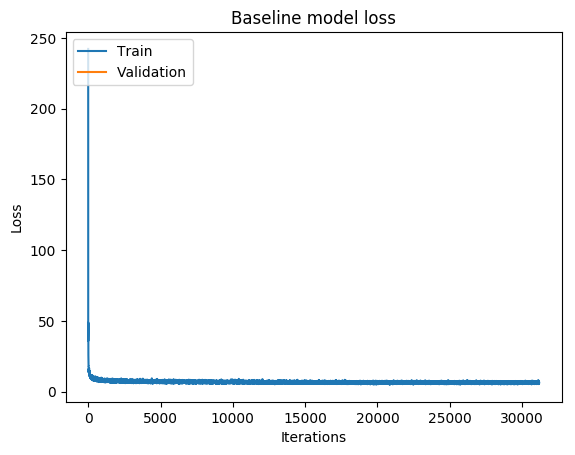

In [0]:
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.title('Baseline model loss')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Plot a sample

100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


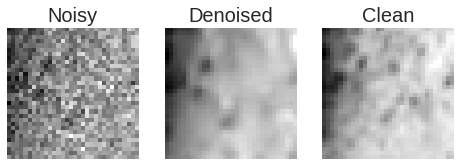

In [0]:
plot_denoise(denoise_model)

## Save Weights

In [0]:
if denoise_train == True:
  denoise_model.save_weights('baseline_denoise.h5')

# Training: Descriptor model
## Loading of data

In [0]:
# Descriptor
if descriptor_train == True:
  hPatches = HPatches(train_fnames = train_fnames, test_fnames = test_fnames)
  descriptor_generator = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 1), num_triplets = 100000)
  descriptor_generator_val = DataGeneratorDesc(*hPatches.read_image_file(hpatches_dir, train = 0), num_triplets = 10000)

Using noisy patches
100%|██████████| 116/116 [00:36<00:00,  3.16it/s]


100%|██████████| 100000/100000 [00:01<00:00, 54891.62it/s]


Using noisy patches
100%|██████████| 116/116 [00:22<00:00,  1.79it/s]


100%|██████████| 10000/10000 [00:00<00:00, 66906.54it/s]


In [0]:
descriptor_model_connected, descriptor_model = get_descriptor_model_connected(SHAPE)
history = None
if descriptor_train == True:
  history = LossHistory()
  sgd = keras.optimizers.SGD(lr = 0.1)
  descriptor_model_connected.compile(loss='mean_absolute_error', optimizer=sgd)
  descriptor_history = descriptor_model_connected.fit_generator(generator=descriptor_generator,
                                                           epochs=1,
                                                           verbose=1,
                                                           steps_per_epoch = 2000,
                                                           validation_steps = 200,
                                                           validation_data=descriptor_generator_val,
                                                           workers=1,
                                                           use_multiprocessing=False,
                                                           callbacks = [history])
else:
  descriptor_model.load_weights('baseline_descriptor.h5')
plot_model(descriptor_model, to_file='baseline_descriptor_arch.png')
print(descriptor_model.summary())

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Epoch 1/1
1999/2000 [============================>.] - ETA: 0s - loss: 0.2294

100%|██████████| 100000/100000 [00:02<00:00, 41673.21it/s]


2000/2000 [==============================] - 167s 84ms/step - loss: 0.2294 - val_loss: 0.2391
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
________________________________________________

## Save Weights

In [0]:
if descriptor_train == True:
  descriptor_model.save_weights('baseline_descriptor.h5')

## Plot Loss

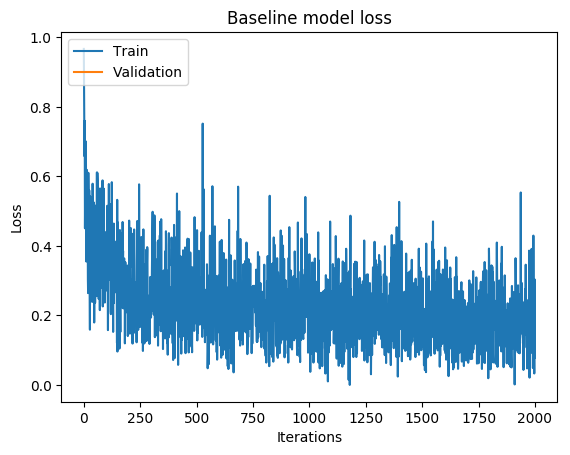

In [0]:
plt.plot(history.losses)
plt.plot(history.val_losses)
plt.title('Baseline model loss')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluation

In [0]:
generate_desc_csv(descriptor_model, denoise_model, seqs_test)
!git clone https://github.com/hpatches/hpatches-benchmark

100%|██████████| 40/40 [06:22<00:00,  5.96s/it]


Cloning into 'hpatches-benchmark'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 1425 (delta 8), reused 11 (delta 4), pack-reused 1409
Receiving objects: 100% (1425/1425), 239.72 MiB | 20.09 MiB/s, done.
Resolving deltas: 100% (786/786), done.
Checking out files: 100% (135/135), done.


## Verification


In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=verification --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=verification


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating verification task
Processing verification task 1/3 : 100% 1000000/1000000 [01:35<00:00, 10526.28it/s]
Processing verification task 2/3 : 100% 1000000/1000000 [01:34<00:00, 10540.35it/s]
Processing verification task 3/3 : 100% 1000000/1000000 [01:35<00:00, 10517.39it/s]
>> Verification task finished in 293 secs  
Verification task results:
CUSTOM - Balanced variant (auc) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.929238  0.897054
Hard     0.909581  0.869982
Tough    0.88026   0.834046
CUSTOM - Imbalanced variant (ap) 
Noise       Inter     Intra
-------  --------  --------
Easy     0.828247  0.741617
Hard     0.761313  0.646158
Tough    0.678073  0.551699


## Retrieval

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=retrieval --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=retrieval


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating retrieval task
>> Please wait, computing distance matrix...
tcmalloc: large alloc 1600004096 bytes == 0x2424a000 @  0x7f0ef814e1e7 0x7f0eeda39a41 0x7f0eeda9cc13 0x7f0eeda9e99e 0x7f0eedb36748 0x5030d5 0x507641 0x504c28 0x502540 0x502f3d 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x506393 0x634d52 0x634e0a 0x6385c8 0x63915a 0x4a6f10 0x7f0ef7d4bb97 0x5afa0a
>> Distance matrix done.
Processing retrieval task: 100% 10000/10000 [03:58<00:00, 41.90it/s]
>> Retrieval task finished in 257 secs  
Retrieval task results:
CUSTOM - mAP 10K queries 
Noise         100       500      1000      5000     10000      15000      20000
-------  --------  --------  --------  --------  --------  ---------  ---------
Easy     0.745674  0.608674  0.55225   0.433877  0.386381  0.361263   0.345439
Hard     0.674654  0.487738  0.41236   0.264553  0

## Matching

In [0]:
!python ./hpatches-benchmark/python/hpatches_eval.py --descr-name=custom --descr-dir=/content/keras_triplet_descriptor/out/ --task=matching --delimiter=";"
!python ./hpatches-benchmark/python/hpatches_results.py --descr=custom --results-dir=./hpatches-benchmark/python/results/ --task=matching


>> Running HPatch evaluation for custom
>> Please wait, loading the descriptor files...
>> Descriptor files loaded.
>> Evaluating matching task
100% 40/40 [02:11<00:00,  4.45s/it]
>> Matching task finished in 131 secs  
Matching task results:
CUSTOM - mAP 
    Easy      Hard      Tough      mean
--------  --------  ---------  --------
0.213868  0.079218  0.0282508  0.107112




## Compressing and saving the CSV files 

In [0]:
!zip -rq baseiline_descriptors.zip ./out/custom